In [340]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import utils.paths as path
import utils.data_cleaning
import missingno

In [341]:
data_dir = path.make_dir_function('data')

In [342]:
df_hurtos = pd.read_csv(data_dir('pre_process','hurtos.csv'),sep=',')
#nuevo df sin columnas innecesarias
df = df_hurtos.copy()
df.drop(['DIRECTORIO', 'NRO_ENCUESTA', 'SECUENCIA_ENCUESTA', 'SECUENCIA_P',
       'ORDEN', 'FEX_C','municipio'],axis=1,inplace=True)

In [343]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16256 entries, 0 to 16255
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   mes_ultimo_unico_robo      16256 non-null  object
 1   metodo                     16256 non-null  object
 2   hora                       16111 non-null  object
 3   lugar                      16256 non-null  object
 4   celular                    16256 non-null  object
 5   efectivo_tarjetas          16256 non-null  object
 6   articulos_de_uso_personal  16256 non-null  object
 7   dispositivos               16256 non-null  object
 8   otra_pertenencia           16256 non-null  object
 9   arma_fuego                 13884 non-null  object
 10  arma_blanca                13884 non-null  object
 11  otros_objetos              13884 non-null  object
 12  fuerza_fisica              13884 non-null  object
 13  drogas_sustancias          13884 non-null  object
 14  hizo_l

# Valores faltantes

In [344]:
#numero de valores faltantes
df.ms_tools.number_missing()

78613

### ¿Qué valores faltantes tenemos por cada columna?

In [345]:
df.isnull().sum()

mes_ultimo_unico_robo            0
metodo                           0
hora                           145
lugar                            0
celular                          0
efectivo_tarjetas                0
articulos_de_uso_personal        0
dispositivos                     0
otra_pertenencia                 0
arma_fuego                    2372
arma_blanca                   2372
otros_objetos                 2372
fuerza_fisica                 2372
drogas_sustancias             2372
hizo_llamada                     0
denuncia                         0
lugar_denuncia               11116
autoridad                    11819
razon_denuncia               11116
buena_atencion               12655
razon_de_satisfaccion        14762
razon_no_denuncia             5140
recuperacion_objeto              0
year                             0
dtype: int64

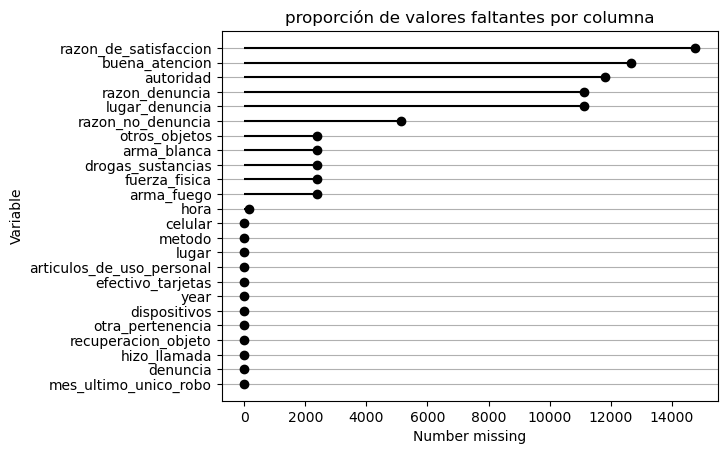

In [346]:
df.ms_tools.vis_variable_plot()
plt.title('proporción de valores faltantes por columna')
plt.show()

# ¿Qué razones pueden haber para que hayan valores faltantes?

<AxesSubplot: >

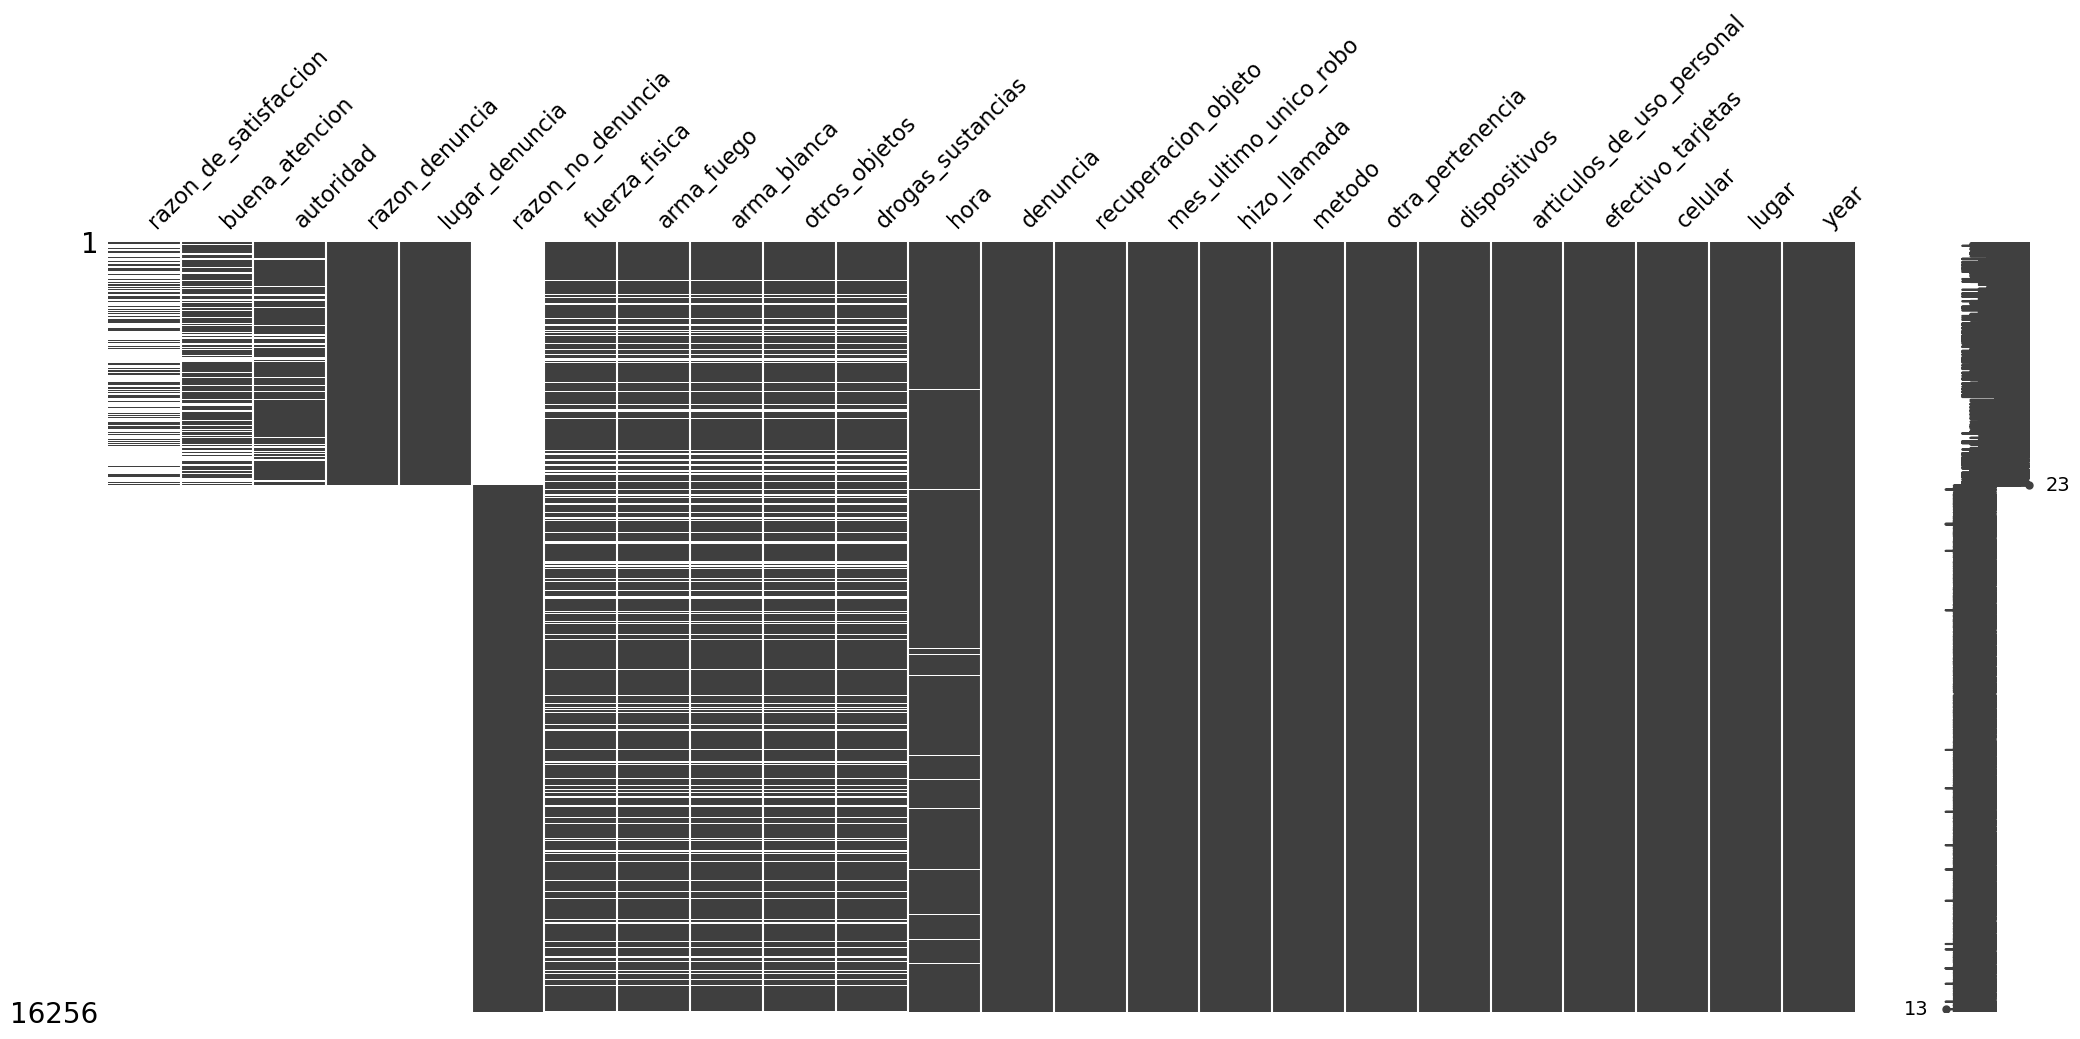

In [347]:
(
    df
    .ms_tools.sort_variables_by_missingness()
    .sort_values(by='razon_denuncia')
    .pipe(missingno.matrix)
)

### Nota:
al hacer la anterior clasificacion caí en cuenta que, la falta de tantos valores nulos
dependía de si la persona hizo o no la denuncia.

por consiguiente procedo a separar las personas que denunciaron y las que no

In [348]:
df_si_denuncia = df[df['denuncia']=='si']
df_no_denuncia = df[df['denuncia']=='no']

## Valores faltantes en personas que no denunciaron

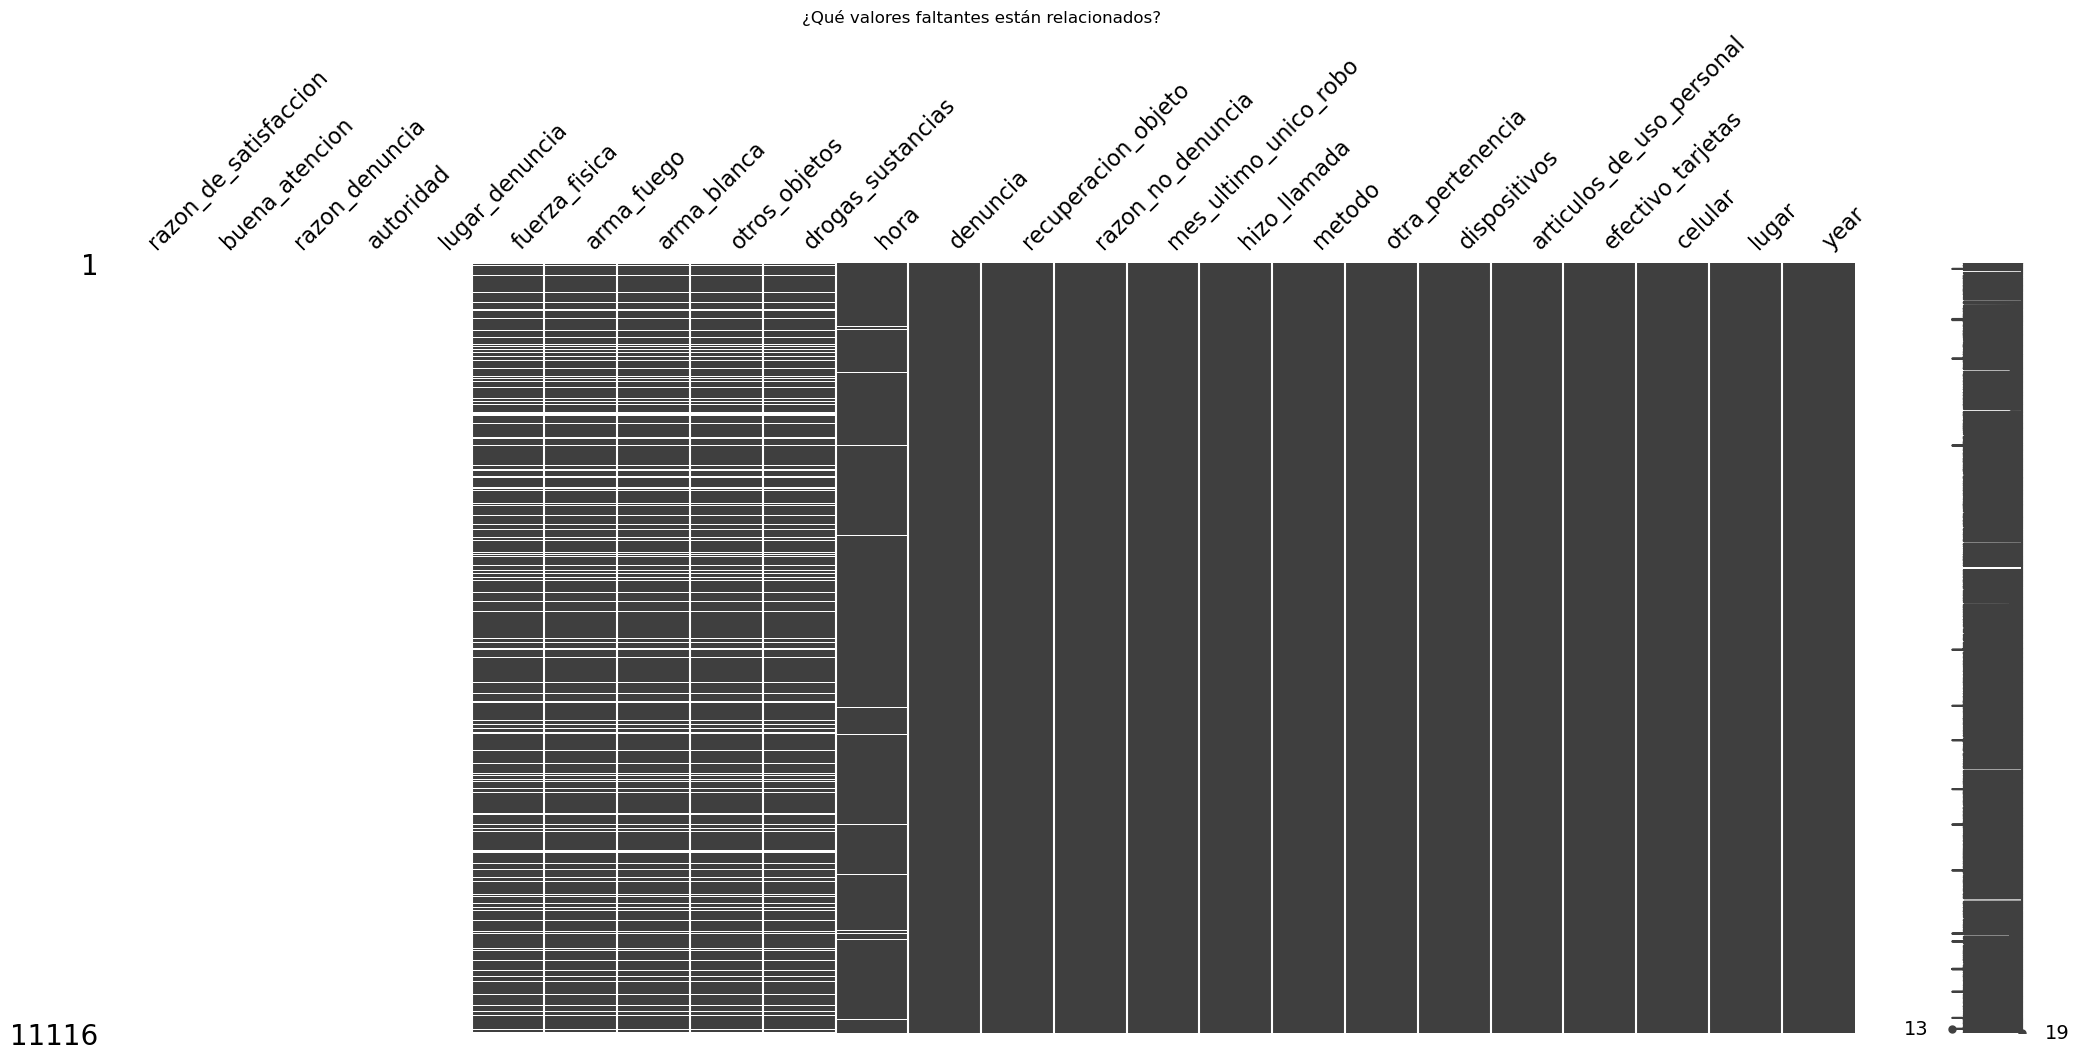

In [349]:
(
    df_no_denuncia
    .ms_tools.sort_variables_by_missingness()
    .sort_values(by='razon_denuncia')
    .pipe(missingno.matrix)
)
plt.title('¿Qué valores faltantes están relacionados?')
plt.show()

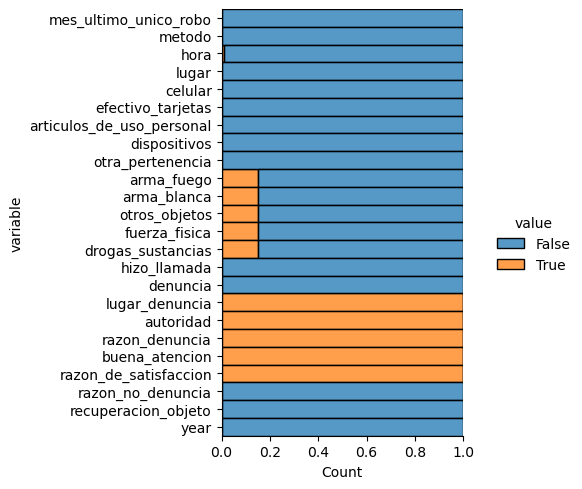

In [350]:
df_no_denuncia.ms_tools.vis_proportion()

### inputación de valores
debido al conocimiento del contexto, voy a rellenar los valores faltantes
de las personas que no denunciaron por "no denuncia" ya que la falta de estos valores
se deben a esa razón

In [351]:
values_to_fill = {
    'lugar_denuncia':'no_denuncia',
    'autoridad':'no_denuncia',
    'razon_denuncia':'no_denuncia',
    'buena_atencion':'no_denuncia',
    'razon_de_satisfaccion':'no_denuncia'
    }

In [352]:
df_no_denuncia = df_no_denuncia.fillna(value=values_to_fill)

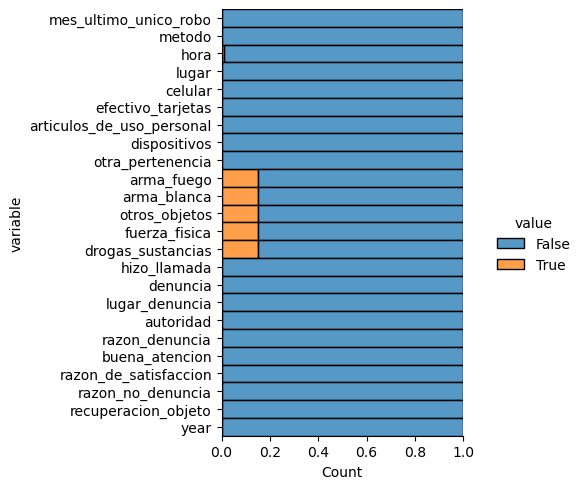

In [353]:
df_no_denuncia.ms_tools.vis_proportion()

## valores nulos para las personas que si denunciaron

<AxesSubplot: >

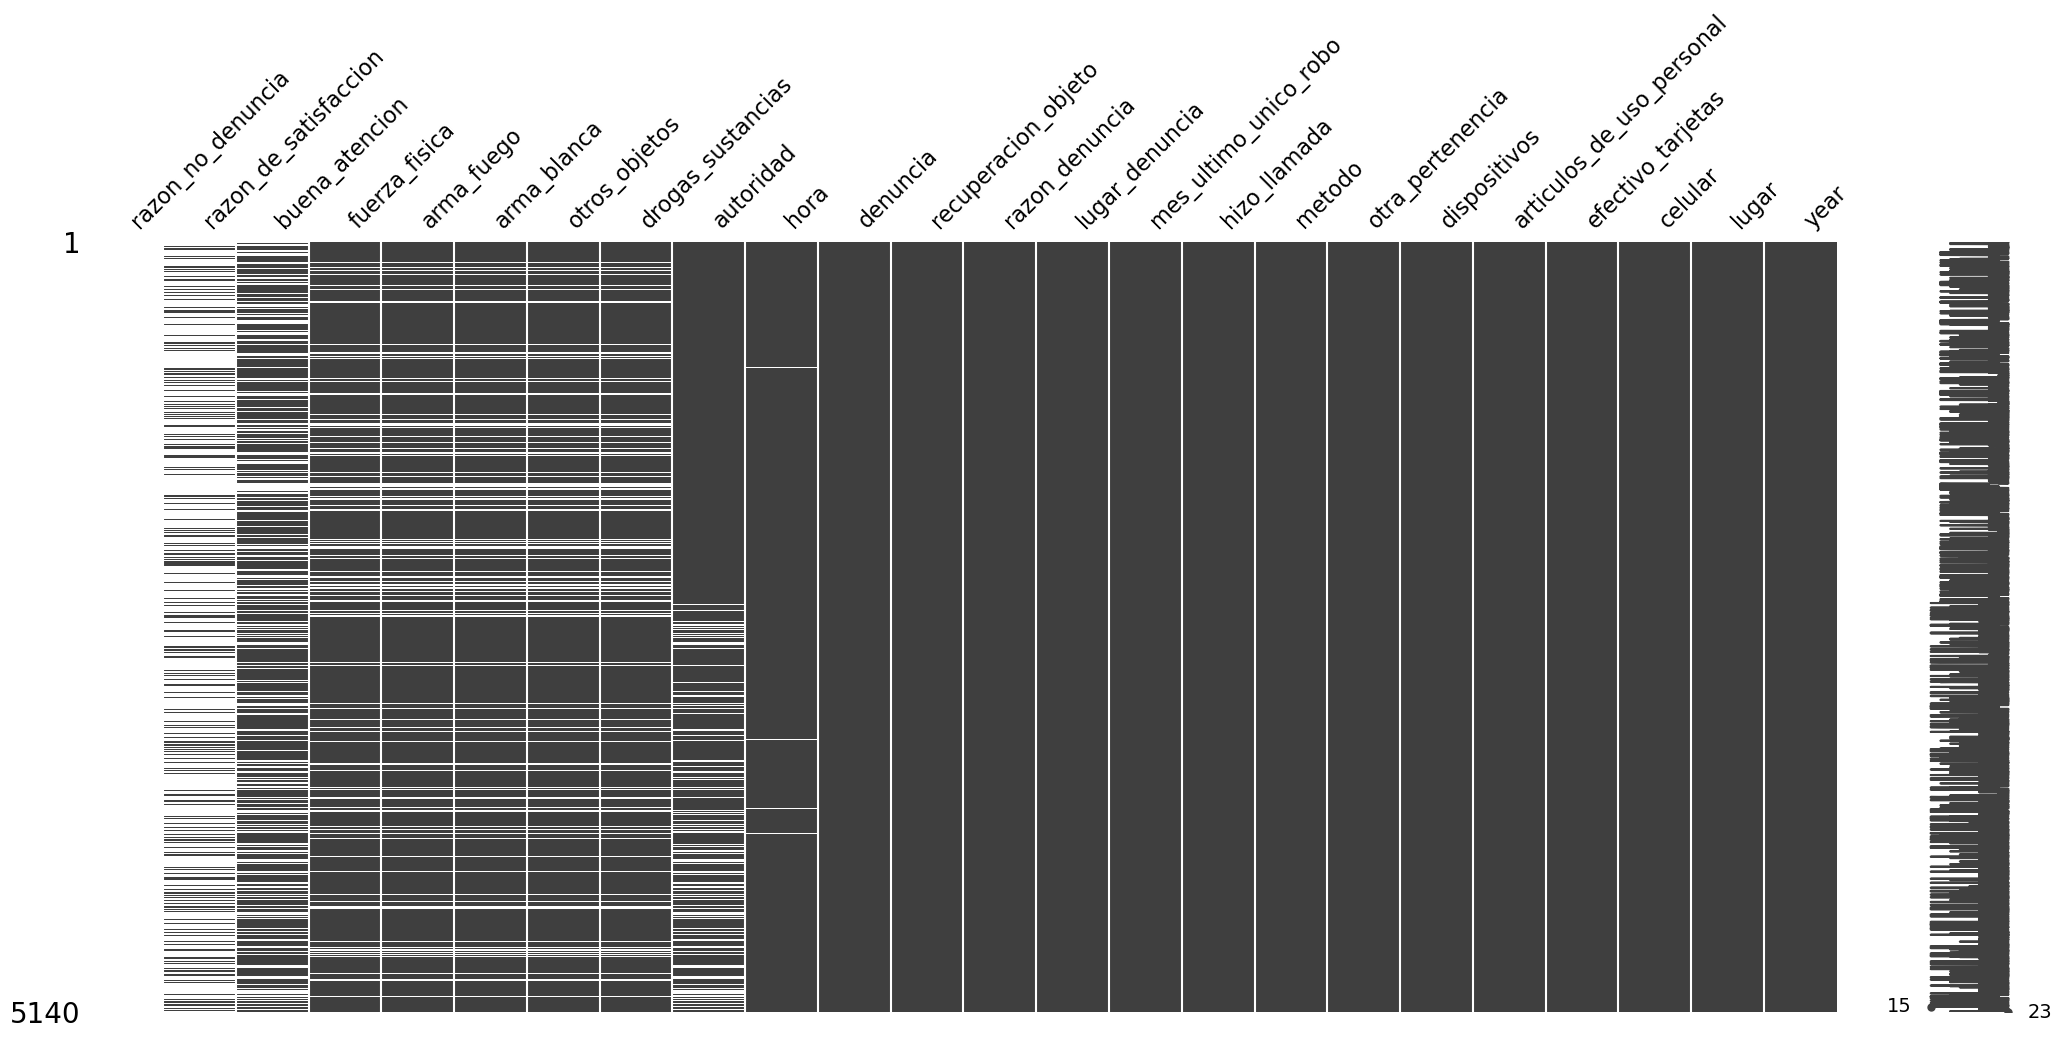

In [354]:
(
    df_si_denuncia
    .ms_tools.sort_variables_by_missingness()
    .sort_values(by='razon_no_denuncia')
    .pipe(missingno.matrix)
)

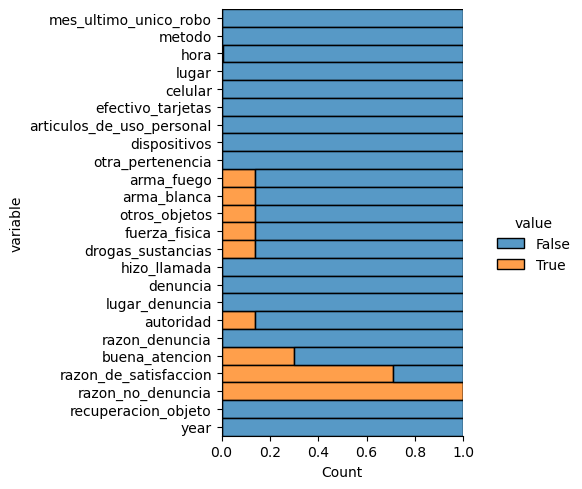

In [355]:
df_si_denuncia.ms_tools.vis_proportion()

### inputación de valores
debido al conocimiento del contexto, voy a rellenar los valores faltantes
de las personas que si denunciaron por "si denuncia" ya que la falta de estos valores
en la columna "razon de la no denuncia" se debe a que estas personas si denunciaron y no 
tenian que responder esta pregunta

In [356]:
df_si_denuncia = df_si_denuncia.fillna(value={'razon_no_denuncia':'df_si_denuncia'})

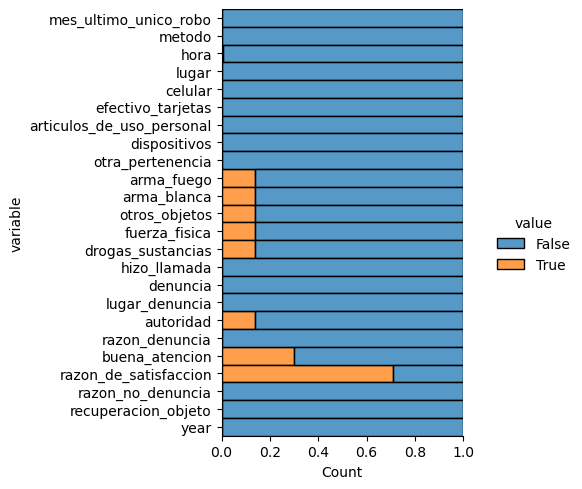

In [357]:
df_si_denuncia.ms_tools.vis_proportion()

# Nuevo DataFrame con sin esos valores nulos

In [358]:
new_df = pd.concat([df_no_denuncia,df_si_denuncia])

In [359]:
#veamos que si tengan los mismos datos
print(df.shape,new_df.shape,sep='\n')

(16256, 24)
(16256, 24)


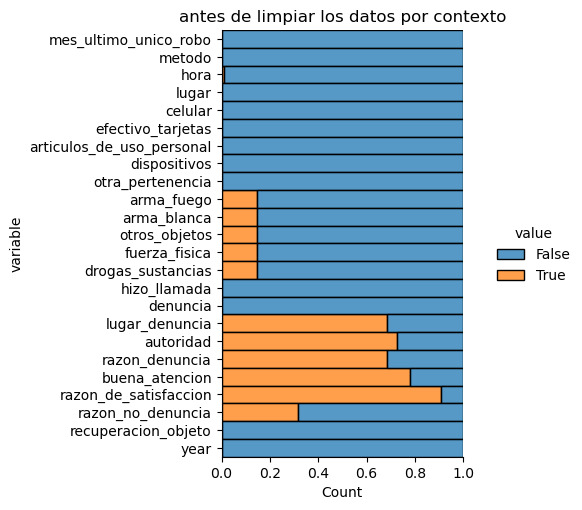

In [360]:
df.ms_tools.vis_proportion()
plt.title("antes de limpiar los datos por contexto")
plt.show()

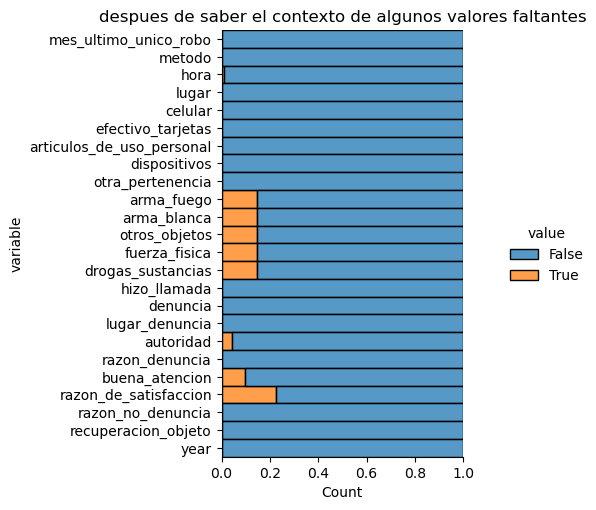

In [361]:
new_df.ms_tools.vis_proportion()
plt.title("despues de saber el contexto de algunos valores faltantes")
plt.show()

In [362]:
new_df.ms_tools.table_variable_summary()

,variable,n_missing,n_cases,pct_missing
0,mes_ultimo_unico_robo,0,16256,0.000000
1,metodo,0,16256,0.000000
2,hora,145,16256,0.891978
3,lugar,0,16256,0.000000
4,celular,0,16256,0.000000
5,efectivo_tarjetas,0,16256,0.000000
6,articulos_de_uso_personal,0,16256,0.000000
7,dispositivos,0,16256,0.000000
8,otra_pertenencia,0,16256,0.000000
9,arma_fuego,2372,16256,14.591535


## ¿Qué factores existen para que falten valores en los objetos que utilizaron en el hurto?:

In [363]:
new_df.columns

Index(['mes_ultimo_unico_robo', 'metodo', 'hora', 'lugar', 'celular',
       'efectivo_tarjetas', 'articulos_de_uso_personal', 'dispositivos',
       'otra_pertenencia', 'arma_fuego', 'arma_blanca', 'otros_objetos',
       'fuerza_fisica', 'drogas_sustancias', 'hizo_llamada', 'denuncia',
       'lugar_denuncia', 'autoridad', 'razon_denuncia', 'buena_atencion',
       'razon_de_satisfaccion', 'razon_no_denuncia', 'recuperacion_objeto',
       'year'],
      dtype='object')

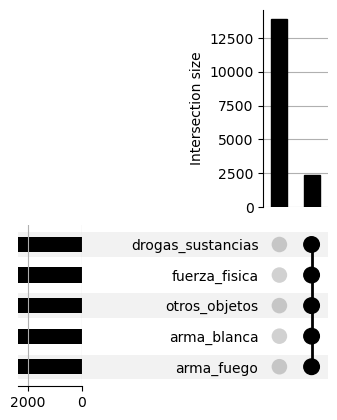

In [364]:
new_df.ms_tools.vis_upsetplot(variables=['arma_fuego', 'arma_blanca', 'otros_objetos',
       'fuerza_fisica', 'drogas_sustancias'])
plt.show()

,razon_de_satisfaccion,fuerza_fisica,arma_fuego,arma_blanca,otros_objetos,drogas_sustancias,buena_atencion,autoridad,hora,denuncia,...,mes_ultimo_unico_robo,hizo_llamada,metodo,otra_pertenencia,dispositivos,articulos_de_uso_personal,efectivo_tarjetas,celular,lugar,year
0,no_denuncia,no,no,si,no,no,no_denuncia,no_denuncia,noche,no,...,marzo,no,atraco,no,no,no,no,si,Calle/Avenida,2018
1,no_denuncia,si,no,si,no,no,no_denuncia,no_denuncia,noche,no,...,junio,no,atraco,no,no,no,si,si,Calle/Avenida,2018
5,no_denuncia,NaN,NaN,NaN,NaN,NaN,no_denuncia,no_denuncia,noche,no,...,junio,no,cosquilleo,no,no,no,no,si,Transporte público,2018
6,no_denuncia,no,no,no,no,no,no_denuncia,no_denuncia,NaN,no,...,mayo,no,raponazo,no,no,no,si,si,Transporte público,2018
7,no_denuncia,no,no,no,no,no,no_denuncia,no_denuncia,madrugada,no,...,mayo,no,descuido,no,no,si,no,no,Trabajo/Estudio,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16226,NaN,no,no,si,no,no,si,policia,tarde,si,...,septiembre,si,atraco,no,no,no,si,si,Calle/Avenida,2020
16231,NaN,no,no,si,no,no,si,policia,tarde,si,...,marzo,no,atraco,no,no,no,si,no,Calle/Avenida,2020
16240,NaN,NaN,NaN,NaN,NaN,NaN,si,fiscalia,tarde,si,...,abril,no,cosquilleo,no,no,no,no,si,Transporte público,2020
16247,NaN,no,si,no,no,no,si,policia,tarde,si,...,noviembre,no,atraco,no,no,no,si,si,Calle/Avenida,2020


#### Proporción de valores nulos por año:

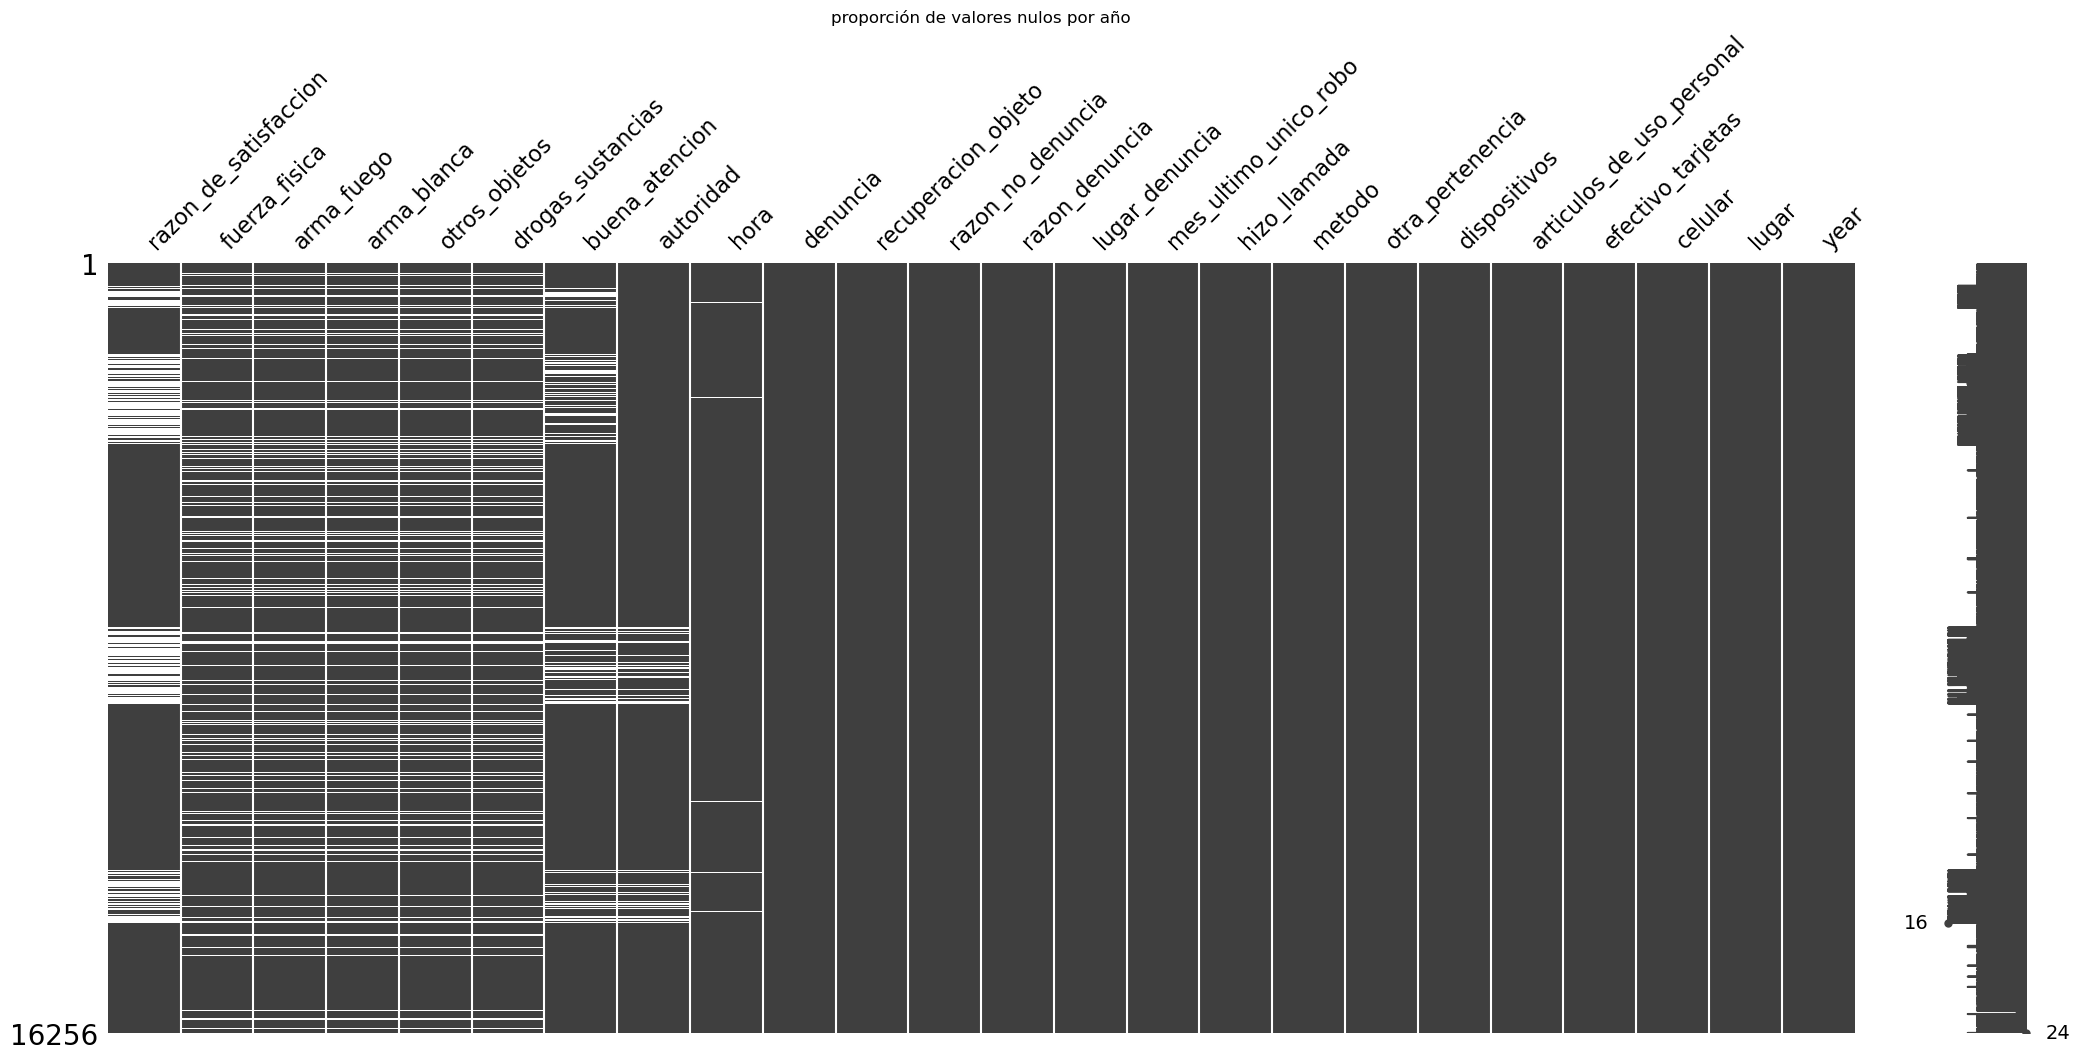

In [392]:
(
    new_df
    .ms_tools
    .sort_variables_by_missingness()
    .sort_values(by='year')
    .pipe(missingno.matrix)
)
plt.show()

#### Nota:
Vemos que no hubieron valores nulos de autoridad en el 2018 y vemos que
hay columnas en donde los valores faltantes se acumulan.